# Сравнение GCNConv сеть с случайным подбрасыванием монетки на данных VK Cup

In [1]:
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 9.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.2/658.2 kB 14.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.7/317.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.0/467.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=3e02d3083cd636a0c13d8bd680b1fb645affdde1cbef101c168f1807a81adf84
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [2]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('../input/vkcup1/train_mod_v3.csv')
df

,Unnamed: 0,u,v,t,h,mask2drop
0,0,0,1,27,6,1
1,1,2,3,13,8,1
2,2,4,5,74,2,1
3,3,6,7,36,9,1
4,4,8,9,52,2,1
...,...,...,...,...,...,...
16745086,17414504,2369189,2300645,6,7,1
16745087,17414505,62448,88256,60,0,1
16745088,17414506,919913,1183054,71,0,1
16745089,17414507,1774,881,67,0,1


In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test.to_csv('test_mod_v3.csv')
del df_test 
#del df

In [4]:
N_TOTAL = max(df['u'].max(), df['v'].max()) + 1
df

,Unnamed: 0,u,v,t,h,mask2drop
0,0,0,1,27,6,1
1,1,2,3,13,8,1
2,2,4,5,74,2,1
3,3,6,7,36,9,1
4,4,8,9,52,2,1
...,...,...,...,...,...,...
16745086,17414504,2369189,2300645,6,7,1
16745087,17414505,62448,88256,60,0,1
16745088,17414506,919913,1183054,71,0,1
16745089,17414507,1774,881,67,0,1


In [5]:
N_TOTAL

2522474

In [6]:
def apk(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = min(len(target), k) 
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            cnt += 1
            ans += cnt / (i + 1)
            s.add(pred[i])
    return ans / tot


def mapk(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += apk(cur_pred, cur_target, k)
    return sum_metric / len(pred) 


In [7]:
df_test = pd.read_csv('test_mod_v3.csv')

target_arr = [[] for _ in range(N_TOTAL)]

for i in range(df_test.shape[0]):
    u, v = df_test['u'].iloc[i], df_test['v'].iloc[i]
    if u >= N_TOTAL or v >= N_TOTAL:
        continue
    target_arr[u].append(v)
    target_arr[v].append(u)
del df_test

In [8]:
import queue
import random
from tqdm.auto import tqdm, trange


def split_dataset(df_edges, n_parts):
    edge2pos = {(df_edges['u'].iloc[i], df_edges['v'].iloc[i]): i for i in trange(df_edges.shape[0])}

    G = [[] for i in range(N_TOTAL)]
    for i in trange(df_edges.shape[0]):
        u, v = df_edges['u'].iloc[i], df_edges['v'].iloc[i]
        G[u].append(v)
        G[v].append(u)
    
    used = set()
    q = queue.Queue()
    for i in range(n_parts):
        u = random.randint(0, N_TOTAL - 1)
        used.add(u)
        q.put((u, i))

    while q.qsize() > 0:
        cur_v, cur_marker = q.get()
        for u in G[cur_v]:
            cur_edge_id = edge2pos[(u, cur_v)] if (u, cur_v) in edge2pos.keys() else edge2pos[(cur_v, u)]
            df_edges['mask2drop'].iloc[cur_edge_id] = cur_marker
            if u not in used:
                q.put((u, cur_marker))
                used.add(u)
    return df_edges

In [9]:
df_train

,Unnamed: 0,u,v,t,h,mask2drop
14097692,14661593,919219,1217619,82,1,1
4783596,4974441,87082,2007029,38,7,1
13307887,13840046,265241,1256101,55,6,1
7756141,8065933,1990566,205510,17,8,1
7746502,8055895,2201947,761537,49,2,1
...,...,...,...,...,...,...
6550634,6812205,4711,95147,58,2,1
16094478,16738025,1444780,1558666,7,6,1
6423388,6679839,208288,690913,82,6,1
15351219,15965024,999702,10275,23,7,1


In [10]:
import networkx as nx
import random
from networkx import ego_graph
from tqdm.auto import trange


class GraphSampler:
    def __init__(self, df, N_PARTS, number_same_graph = 10000, number_same_graph2 = 70000):
        self.df = split_dataset(df, N_PARTS)
        self.N_PARTS = N_PARTS
        self.number_same_graph = number_same_graph
        self.number_same_graph2 = number_same_graph2
        self.DF_TRAIN = []
        self.iteration = 0
        df1 = df
        for i in range(N_PARTS):
            df_cur = self.df[self.df['mask2drop'] == i]
            self.DF_TRAIN.append(df_cur)
        self.cur_graph = nx.Graph()

        self.edges_set = [set() for i in range(N_TOTAL)]
        for i in trange(self.df.shape[0]):
            u, v = self.df['u'].iloc[i], self.df['v'].iloc[i]
            self.edges_set[u].add(v)
            self.edges_set[v].add(u)

    def __getitem__(self, index):
        del self.cur_graph
        self.cur_graph = nx.Graph()
        self.cur_graph.add_nodes_from(list(range(N_TOTAL)))
        self.cur_graph.add_edges_from(self.DF_TRAIN[index][['u', 'v']].values)


    def get_random_subgraph(self, size_graph):
        mask = np.random.choice(self.indices, size=size_graph)
        return self.cur_graph.subgraph(self.indices[mask])

    def get_random_connected(self, thr=10):
        v0 = random.randint(0, N_TOTAL - 1)
        g0 = ego_graph(self.cur_graph, n=v0, radius=1)
        if len(g0.nodes) < thr:
            g0 = ego_graph(self.cur_graph, n=v0, radius=2)
        return g0

    def generate_random_graph(self, p_connected, size_graph, thr=10):
        if self.iteration % self.number_same_graph == 0:
            self.__getitem__(random.randint(0, self.N_PARTS - 1))
        self.iteration += 1
        if random.random() < p_connected:
            return self.get_random_connected(thr)
        else:
            return self.get_random_subgraph(size_graph)

    @torch.no_grad()
    def inference_model(self, model, num_samples_big, degree_threshold, diameter, K, lim2evaluate = None):
        sum_apk, cnt_apk = 0, 1e-9
        n_vertexes = lim2evaluate if lim2evaluate is not None else N_TOTAL
        for i in trange(n_vertexes):
            if len(target_arr[i]) == 0:
                continue
            if self.iteration % self.number_same_graph2 == 0:
                self.__getitem__(random.randint(0, self.N_PARTS - 1))
            self.iteration += 1
            recommendations = []
            if len(self.edges_set[i]) >= degree_threshold:
                g0 = ego_graph(self.cur_graph, n=i, radius=diameter)
                vertexes = list(g0.nodes)
                id2pos = {val: pos for pos, val in enumerate(vertexes)}
                test_edges = []
            
                for v0 in vertexes:
                    if v0 not in self.edges_set[i] and i not in self.edges_set[v0]:
                        test_edges.append((i, v0))
                    
                output = model(g0)
                pred_logits = [(torch.sum(output[id2pos[v0]] * output[id2pos[v1]]).item(), ind)
                           for ind, (v0, v1) in enumerate(test_edges)]
                pred_logits = sorted(pred_logits)[::-1][:K]
                recommendations = [ind for _, ind in pred_logits]
            else:
                g0 = nx.Graph()
                g0.add_node(i)
                for _ in range(num_samples_big):
                     g0.add_node(random.randint(0, N_TOTAL - 1))
                vertexes = list(g0.nodes)
                id2pos = {val: pos for pos, val in enumerate(vertexes)}
                test_edges = []
            
                for v0 in vertexes:
                    if v0 not in self.edges_set[i] and i not in self.edges_set[v0]:
                        test_edges.append((i, v0))
                    
                output = model(g0)
                pred_logits = [(torch.sum(output[id2pos[v0]] * output[id2pos[v1]]).item(), ind)
                           for ind, (v0, v1) in enumerate(test_edges)]
                pred_logits = sorted(pred_logits)[::-1][:K]
                recommendations = [ind for _, ind in pred_logits]
            
            sum_apk += apk(recommendations, target_arr[i], K)
            cnt_apk += 1
        return sum_apk / cnt_apk
    

In [11]:
graph_manager = GraphSampler(df_train, 60)

  0%|          | 0/13396072 [00:00<?, ?it/s]

  0%|          | 0/13396072 [00:00<?, ?it/s]

  0%|          | 0/13396072 [00:00<?, ?it/s]

## 1. Baseline

## Сетка из GCNConv:

In [12]:
#import networkx as nx
#G_train = nx.Graph()

#G_train.add_nodes_from(list(range(N_TOTAL)))

#G_train.add_edges_from(df_train[['u', 'v']].values)

In [13]:
#G_degree = np.zeros(N_TOTAL)
#for u, v in edges_set:
#    G_degree[u] += 1
#    G_degree[v] += 1


In [14]:
#import random

#N_samples = 1000000

#sum_d, cnt_d = 0, 0

#for i in range(N_samples):
#    v = random.randint(0, N_TOTAL - 1)
#    if G_degree[v] >= 20:
#        u = random.randint(0, N_TOTAL - 1)
#        try:
#            sum_d += nx.shortest_path_length(G_train, u, v) 
#            cnt_d += 1
#        except:
#            pass 

#sum_d / cnt_d

In [15]:
device = torch.device('cpu') 
device

device(type='cpu')

In [16]:
import torch 
import torch.nn as nn
import torch_geometric as tg
from torch_geometric.utils.convert import to_networkx, from_networkx

class GCNModel(nn.Module):
    def __init__(self, num_vertexes, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(num_vertexes, embedding_dim)
        self.layers = nn.ModuleList([])
        self.layers.append(tg.nn.GCNConv(embedding_dim, hidden_dim))
        self.relu = nn.ReLU()
        for i in range(num_layers):
            self.layers.append(tg.nn.GCNConv(hidden_dim, hidden_dim))
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, graph):
        input_data = from_networkx(graph)
        input_vertexes = torch.tensor(list(graph.nodes)).to(device)
        hidden = self.embedding(input_vertexes)
        for layer in self.layers:
            hidden = layer(hidden, input_data.edge_index.to(device))
            hidden = self.relu(hidden)
        return self.last(hidden)

In [17]:
class BPRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, logits, mask_positive):
        positive_scores = logits[mask_positive].reshape(-1, 1)
        negative_scores = logits[~mask_positive].reshape(1, -1)
        sum_loss = 0
        m1 = torch.ones(1, negative_scores.shape[1]).to(device)
        m2 = torch.ones(positive_scores.shape[0], 1).to(device)

        diff = -torch.log(self.sigmoid((positive_scores @ m1) - (m2 @ negative_scores)))
        sum_loss = torch.sum(diff)

        sum_loss /= len(positive_scores)
        sum_loss /= len(negative_scores)
        return sum_loss


In [18]:
model = GCNModel(N_TOTAL, 16, 64, 2).to(device)
criterion = BPRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [19]:
from networkx import ego_graph
import networkx as nx
from tqdm.auto import trange

iterations = 300000
batch_size = 16
save_every = 100
evaluate_every = 500
lim2evaluate = 15000


pbar = trange(iterations)

values_loss, values_metric = [],  []

for iteration in pbar:
    if iteration % 10000 == 0:
        print(iteration)
    optimizer.zero_grad()
    input_graph = graph_manager.generate_random_graph(1, 14)
    vertexes = list(input_graph.nodes)
    id2pos = {val: pos for pos, val in enumerate(vertexes)}
    test_edges = []

    for i in range(batch_size):
        v0 = random.choice(vertexes)
        v1 = random.choice(vertexes)
        ITERATIONS = 100
        while v1 == v0 or (v0, v1) in test_edges or (v1, v0) in test_edges:
            v0 = random.choice(vertexes)
            v1 = random.choice(vertexes)
            ITERATIONS -= 1
            if ITERATIONS == 0:
                break
        if ITERATIONS == 0:
            break
        test_edges.append((v0, v1))
  
    if len(test_edges) == 0:
        continue
    labels = torch.tensor([edge in input_graph.edges for edge in test_edges]).to(device)
    if sum(labels) == 0 or sum(labels) == len(labels):
        continue
    input_graph.remove_edges_from(test_edges)
    output = model(input_graph)
    pred_logits = torch.cat([torch.sum(output[id2pos[v0]] * output[id2pos[v1]]).reshape(-1) for v0, v1 in test_edges], 0)
    loss = criterion(pred_logits, labels) 
    pbar.set_description(f"train loss: {loss.item()}")
    loss.backward()
    values_loss.append(loss.item())
    optimizer.step()

    if iteration % save_every == save_every - 1:
        torch.save(model, "start_model.pt")
    if iteration % evaluate_every == evaluate_every - 1:
        values_metric.append(graph_manager.inference_model(model, 50, 20, 3, 30, lim2evaluate))
        print(values_metric[-1], iteration)

  0%|          | 0/300000 [00:00<?, ?it/s]

0
10000
20000
30000


  0%|          | 0/15000 [00:00<?, ?it/s]

1.875546548264997e-05 37999
40000


  0%|          | 0/15000 [00:00<?, ?it/s]

8.809338623314849e-06 42499


  0%|          | 0/15000 [00:00<?, ?it/s]

1.2005034743477946e-05 42999
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000


  0%|          | 0/15000 [00:00<?, ?it/s]

2.1733060902513044e-05 187999
190000
200000


  0%|          | 0/15000 [00:00<?, ?it/s]

1.013844722635857e-05 205999
210000
220000
230000
240000
250000
260000
270000


  0%|          | 0/15000 [00:00<?, ?it/s]

4.412002597120241e-06 276999
280000
290000


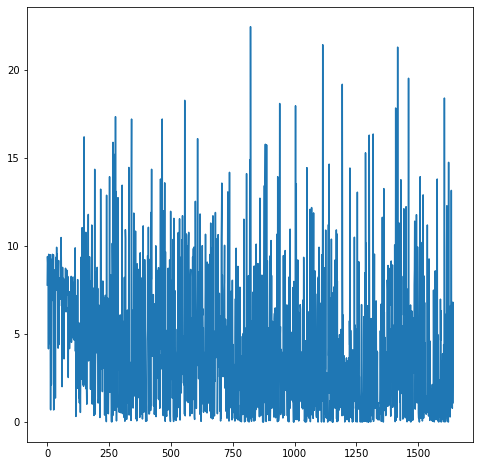

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))
plt.plot(np.arange(0, len(values_loss)), values_loss);

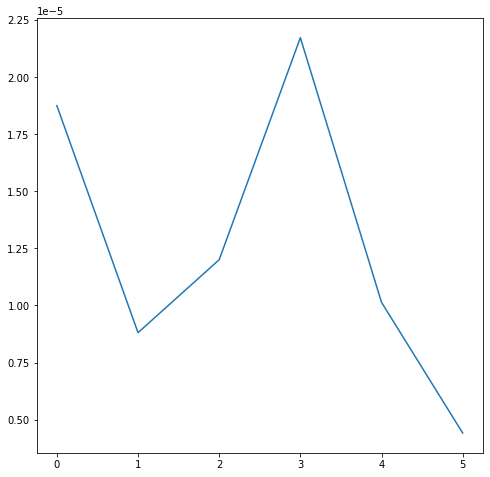

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))
plt.plot(np.arange(0, len(values_metric)), values_metric);

In [22]:
import pickle
with open("metrics.txt", 'wb') as f:
    pickle.dump(values_metric, f)

with open("losses.txt", 'wb') as f:
    pickle.dump(values_loss, f)
